In [11]:
!pip install tqdm
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


gpg: keybox '/tmp/tmpbesrk_l1/pubring.gpg' created
gpg: /tmp/tmpbesrk_l1/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [12]:
from google.colab import auth
auth.authenticate_user()


from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


··········


In [13]:

!mkdir -p drive
!google-drive-ocamlfuse drive

print('Files in Drive:')
!ls drive/Dataset/


fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
Files in Drive:
classifier.ipynb	  melanoma			    test
Compressed		  others			    train
Image_segmentation.ipynb  Preprocessing_segmentation.ipynb


In [0]:
import cv2
from tqdm import tqdm
import numpy as np
import os
from random import shuffle

In [0]:
TRAIN_DIR = 'drive/Dataset/train'
TEST_DIR = 'drive/Dataset/test'
IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = 'skin_cancer-{}-{}.model'.format(LR, '2conv-basic')

In [0]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'beg': return [1,0]
    elif word_label == 'mal': return [0,1]

In [0]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [0]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [0]:
train_data = create_train_data()

100%|██████████████████████████████████████| 2000/2000 [06:22<00:00,  5.23it/s]


In [0]:
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')


hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from C:\Python35\Scripts\skin_cancer-0.001-2conv-basic.model
model loaded!


In [0]:
train = train_data[:-500]
test = train_data[-500:]


In [0]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]




In [0]:
model.fit({'input': X}, {'targets': Y}, n_epoch=20, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 2399  | total loss: 0.14737 | time: 7.416s
| Adam | epoch: 020 | loss: 0.14737 - acc: 0.9577 -- iter: 1472/1500
Training Step: 2400  | total loss: 0.14132 | time: 8.748s
| Adam | epoch: 020 | loss: 0.14132 - acc: 0.9588 | val_loss: 0.35682 - val_acc: 0.8820 -- iter: 1500/1500
--
INFO:tensorflow:C:\Python35\Scripts\skin_cancer-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 52.73it/s]


Prediction Result:


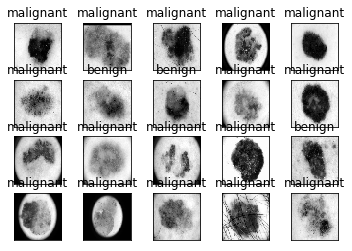

In [0]:
import matplotlib.pyplot as plt
#test_data = np.load('test_data.npy')
test_data = process_test_data()
fig=plt.figure()
print("Prediction Result:")
for num,data in enumerate(test_data[:20]):
    # benign: [1,0]
    # malignant: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(4,5,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='malignant'
    else: str_label='benign'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()

In [0]:

Y_true=[i[1] for i in test]



In [0]:
Y_pred=[]
for num,data in enumerate(test):
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    Y_pred.append(model_out)
    
   

In [0]:
print(Y_pred)
for data in (Y_pred):
    if data[0]>0.5: data[0]=int(1)
    else: data[0]=int(0)
    if data[1]>0.5: data[1]=int(1)
    else: data[1]=int(0)

[array([9.9981350e-01, 1.8649924e-04], dtype=float32), array([0.99195194, 0.00804809], dtype=float32), array([0.9987841 , 0.00121594], dtype=float32), array([9.9991715e-01, 8.2870261e-05], dtype=float32), array([9.9974567e-01, 2.5437193e-04], dtype=float32), array([9.9923491e-01, 7.6507864e-04], dtype=float32), array([9.9987006e-01, 1.2995682e-04], dtype=float32), array([0.9925217 , 0.00747833], dtype=float32), array([0.5217562, 0.4782439], dtype=float32), array([0.7892312 , 0.21076879], dtype=float32), array([0.9460923 , 0.05390764], dtype=float32), array([9.9999273e-01, 7.2544303e-06], dtype=float32), array([0.9957858 , 0.00421421], dtype=float32), array([0.9974105 , 0.00258956], dtype=float32), array([0.7273857 , 0.27261433], dtype=float32), array([0.00637517, 0.9936248 ], dtype=float32), array([9.9994195e-01, 5.8012160e-05], dtype=float32), array([0.98489213, 0.01510781], dtype=float32), array([0.99863905, 0.00136093], dtype=float32), array([0.03292503, 0.96707493], dtype=float32),

In [0]:
print(Y_pred)

[array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([0., 1.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([0., 1.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([0., 1.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([

In [0]:
from sklearn.metrics import confusion_matrix
y_true=[]
y_pred=[]
for data in (Y_true):
    if(data[0]==1 and data[1]==0):
        y_true.append(1)
    else: y_true.append(0)

for data in (Y_pred):
    if(data[0]==1 and data[1]==0):
        y_pred.append(1)
    else: y_pred.append(0)
        

cm=confusion_matrix(y_true, y_pred)


In [0]:
print("Confusion Matrix of Melonoma")
print("-----------------------------")
print("          Benign | Malignant")
for i in (1,0):
    if i==1: print("Benign   |",end=' ')
    else: print("Malignant|",end=' ') 
    for j in (1,0):
        print(cm[i][j],end='      ') 
    print()

Confusion Matrix of Melonoma
-----------------------------
          Benign | Malignant
Benign   | 390      23      
Malignant| 36      51      


In [0]:
a=cm[1][1]
b=cm[1][0]
c=cm[0][1]
d=cm[0][0]


In [0]:
print("Precision and Recall for Benign Class")
print("---------------------------------------")
print("Precision:",end=' ')
print(a/(a+c))
print("Recall:",end=' ')
print(a/(a+b))
print("----------------------------------------")

Precision and Recall for Benign Class
---------------------------------------
Precision: 0.9154929577464789
Recall: 0.9443099273607748
----------------------------------------


In [0]:
print("Precision and Recall for Malignant Class")
print("---------------------------------------")
print("Precision:",end=' ')
print(b/(b+d))
print("Recall:",end=' ')
print(b/(a+b))
print("----------------------------------------")

Precision and Recall for Malignant Class
---------------------------------------
Precision: 0.3108108108108108
Recall: 0.05569007263922518
----------------------------------------
